In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
%matplotlib inline

from bs4 import BeautifulSoup
import requests
import random
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.firefox.options import Options
import spacy

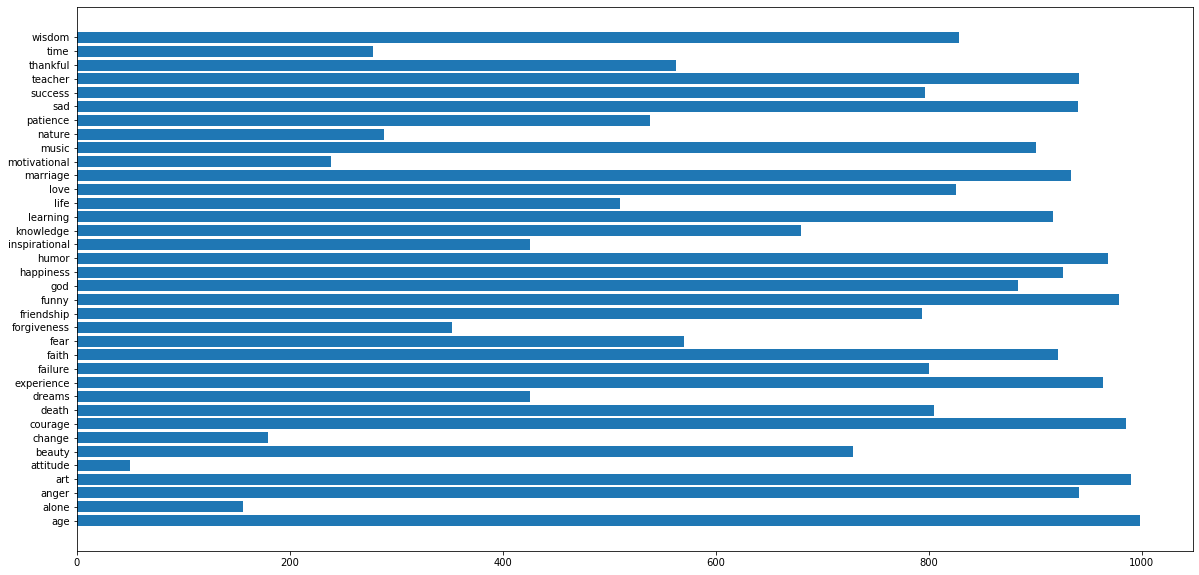

In [54]:
# read in full_quotes.csv generated in quotes_scrape
df = pd.read_csv('full_quotes.csv')
subtopics = list(df.label.unique())
# plot counts for each label
plt.figure(figsize=(20,10))
plt.barh(df.groupby('label')['quote'].agg('count').index, df.groupby('label')['quote'].agg('count').values)
plt.show()

In [4]:
nlp = spacy.load('en_core_web_lg')

In [5]:
def cosine_similarity(a, b):
    return a.dot(b)/np.sqrt(a.dot(a) * b.dot(b))

vectorize quotes, generate a mean vector

In [6]:
# Takes 15 minutes to vectorize ~25000 quotes
with nlp.disable_pipes():
    vectors_full = np.array([nlp(text).vector for text in df.quote])

In [55]:
vec_mean = vectors_full.mean(axis=0)

Generate distance matrix between quote labels

In [77]:
def compare_labels(a, b, N=10):
    with_a = df.loc[df.label == a].sample(n=N, random_state=1)
    with_b = df.loc[df.label == b].sample(n=N, random_state=1)

    with nlp.disable_pipes():
        quote_vectors_a = np.array([nlp(text).vector for text in with_a.quote]) - vec_mean
        quote_vectors_b = np.array([nlp(text).vector for text in with_b.quote]) - vec_mean
    similarity = []
    for x in quote_vectors_a:
        for y in quote_vectors_b:
            similarity.append(cosine_similarity(x, y))
    score = np.mean(similarity)
    return score

In [92]:
def series_label(label):
    return pd.Series([compare_labels(label, i) for i in subtopics], index=subtopics, name=label)

In [96]:
%%time 
matrix_sim = pd.concat([series_label(label) for label in subtopics], axis=1)

CPU times: user 10min 48s, sys: 4.11 s, total: 10min 52s
Wall time: 10min 59s


Hierarchical Clustering for quote labels

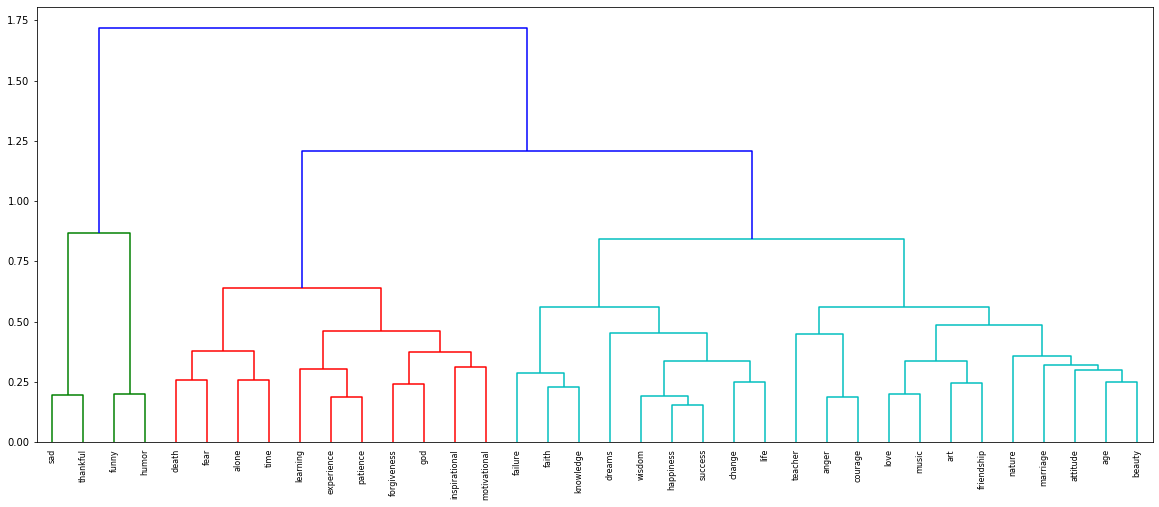

In [111]:
matrix_dist = 1 - matrix_sim
fig, ax1 = plt.subplots(figsize=(20, 8))

corr_linkage = hierarchy.ward(matrix_dist)
dendro1 = hierarchy.dendrogram(corr_linkage, labels=subtopics, ax=ax1,
                              leaf_rotation=90)
dendro1_idx = np.arange(0, len(dendro1['ivl']))

Labels are too similar and non-distinguishing to do any meaningful type of classification

In [60]:
# Center vectors_full using vec_mean
quotes_centered = vectors_full - vec_mean

def similar_quote(sample):
    """
    Returns the quote from brainyquote database that is most similar to an input sample
    """
    sample_vec = nlp(sample).vector
    sims = np.array([cosine_similarity(sample_vec - vec_mean, quote) for quote in quotes_centered])
    most_similar = sims.argmax()
    print(df.iloc[most_similar].quote, '-', df.iloc[most_similar].author)

In [61]:
similar_quote('Life would be so empty without art and music')

'I can't satisfy myself with just trying to tie all of my imagination into music, especially when music is not appreciated as an art form as much as it used to be.' -  Marilyn Manson


In [65]:
similar_quote('You always end up with the person you are meant to be with')

'Always continue the climb. It is possible for you to do whatever you choose, if you first get to know who you are and are willing to work with a power that is greater than ourselves to do it.' -  Ella Wheeler Wilcox


Despite some similarities in syntax, some of the returned quotes are very misleading...

In [64]:
similar_quote('Never ever ever ever ever give up.')

'The most important thing for me was to never, ever, ever deny it. But I didn't really have the courage to talk about it. I was thinking, The people who need to know I'm gay know.' -  Portia de Rossi
